In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn import datasets

SEED=200
plt.ion()

# Implementar uma das duas funções abaixo:
## Reescalar entre 0 e 1 ou Normalização z-score

In [2]:
def rescale(df, columns, maximum=None, minimum=None):
    """
    df: dataframe com o dataset
    columns: nomes das colunas que devem ser reescaladas
    maximum: dicionário com os valores maximos, com cada chave representando uma coluna
    minimum: dicionário com os valores minimos, com cada chave representando uma coluna
    retorna o dataset reescalado
    """
    raise NotImplementedError("implementar a função rescale")

def normalize(df, columns, mean=None, std=None):
    """
    df: dataframe com o dataset
    columns: nomes das colunas que devem ser normalizadas
    mean: dicionário com os valores médios, com cada chave representando uma coluna
    std: dicionário com os desvios padrão, com cada chave representando uma coluna
    retorna o dataset normalizado
    """
    if mean and std:
        for c in columns:
            df[c] = df[c].apply(lambda x: ((x - mean[c]) / std[c]))
        return df, mean, std
    
    # normalize each defined column 
    for c in columns:
        if not mean:
            mean = {}
        if not std:
            std = {}
        mean[c] = mean[c] if c in mean else df[c].mean()
        std[c] = std[c] if c in std else df[c].std()
    return df, mean, std
    

# A célula seguinte carrega o dataset. Não é necessário modificar.

In [3]:
"""Load dataset"""
iris = datasets.load_iris()

df_full = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                       columns= iris['feature_names'] + ['target'])

def get_train_test_inds(y, train_proportion=0.7):
    """
    y: coluna do atributo alvo
    retorna os indices de treino e teste estratificados pela classe
    """
    y=np.array(y)
    train_inds = np.zeros(len(y),dtype=bool)
    test_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y)
    for value in values:
        value_inds = np.nonzero(y==value)[0]
        np.random.shuffle(value_inds)
        n = int(train_proportion*len(value_inds))

        train_inds[value_inds[:n]]=True
        test_inds[value_inds[n:]]=True

    return train_inds,test_inds


train_inds, test_inds = get_train_test_inds(df_full.loc[:, "target"])
df_full[['target']] = df_full[['target']].astype(int)
df = df_full[train_inds]
df_val = df_full[test_inds]

In [4]:
"""Use este trecho no caso de optar por reescalar"""
# df, maximum, minimum = rescale(df, df.columns[0:4])
# df_val, _, _ = rescale(df_val, df_val.columns[0:4], maximum, minimum)

"""Use este trecho no caso de optar por normalizar"""
df, mean, std = normalize(df, df.columns[0:4])
df_val, _, _ = normalize(df_val, df_val.columns[0:4], mean, std)

/Users/arielril/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Funções de Ativação e Softmax
## Implementar Relu, Sigmoid e Softmax

In [5]:
class Relu(object):
    def forward(self, x):
        """
        x: Entrada (batch_size, numero_de_neuronios) (10x4) => input layer size == 4 (neuron number)
        retorna a saída da ativação ReLu (batch_size, numero_de_neuronios) (10x4) 
            => output layer size == 4 (neuron number)
        
        Function: returns the max between the value(x) and 0 (zero)
        """
        return np.maximum(x, 0)
    
    def backward(self, x):
        """
        x: Entrada no backward (batch_size, numero_de_neuronios)
        retorna a saída da derivada da ativação relu (batch_size, numero_de_neuronios)
        
        Function: 
            - if the value(x) is grater than 0, set the value(x) to 1
            - otherwise, set the value(x) to 0
        """
        x[x<=0] = 0
        x[x>0] = 1
        return x

        
class Sigmoid(object):
    def forward(self, x):
        """
        x: Entrada (batch_size, numero_de_neuronios) (NxM)
        retorna a saída da ativação sigmoidal (batch_size, numero_de_neuronios) (NxM) 
            => output layer size == 4 (neuron number)
        
        Function: squashes the values in the range [0, 1]
            -> base sigmoid
        """
        return 1. / (1. + np.exp(-x))
        
    def backward(self, x):
        """
        x: Entrada no backward (batch_size, numero_de_neuronios) (NxM)
        retorna a saída da derivada da ativação sigmoidal (batch_size, numero_de_neuronios) (NxM)
        
        Function: set the value(x) in the range of [0, .25]
            -> sigmoid derivative
        """
        return (1. - x) * x
        

def softmax(x):
    """
    APPLY TO THE LAST HIDDEN LAYER 
    
    x: Entrada (batch_size, numero_de_neuronios) (NxM)
    retorna a probabilidade de cada classe (batch_size, numero_de_neuronios) (NxM)
    """
    exps = np.exp(x - np.amax(x, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)
    


# A célula seguinte implementa uma Rede Neural com 2 camadas escondidas. 

In [6]:
class NeuralNetwork(object):
    """
    PARAMS:
    - input layer size => 4 (neurons, 4x1)
    - hidden layers:
        - h1 size => 10 (neurons => vertical vector)
        - h2 size => 10 (neurons => vertical vector)
    - output layer size => 3 (neurons, 3x1)
    - learning rate => 1.e-3
    - sigma => 1.
    - activation fn => 'relu' or 'sigmoid'
    - weight decay => 0.0001
    """
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size,
                 activation_fn='relu', learning_rate=1e-2, sigma=1., weight_decay=0.1):
        """Inicializacao pronta. Nao alterar"""
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.sigma = sigma
        
        # relu or sigmoid
        if activation_fn == 'relu':
            self.activation_fn = Relu()
        elif activation_fn == 'sigmoid':
            self.activation_fn = Sigmoid()
        
        """
        WEIGHTS and BIASES:
            - w1 (4x10)
            - b1 (10x)
            ------------
            - w2 (10x10)
            - b2 (10x)
            -----------
            - w3 (10x3)
            - b3 (3x)
            -----------
        """
        
        # inicializa as matrizes dos parametros, init with random values
        self.params = {}
        self.params["w1"] = sigma * np.random.randn(input_size, hidden_size1)
        self.params["b1"] = np.zeros(hidden_size1)
        self.params["w2"] = sigma * np.random.randn(hidden_size1, hidden_size2)
        self.params["b2"] = np.zeros(hidden_size2)
        self.params["w3"] = sigma * np.random.randn(hidden_size2, output_size)
        self.params["b3"] = np.zeros(output_size)
        
        # inicializa as matrizes de gradientes, init with 0
        self.grads = {}
        self.grads["w1"] = np.zeros((input_size, hidden_size1))
        self.grads["b1"] = np.zeros(hidden_size1)
        self.grads["w2"] = np.zeros((hidden_size1, hidden_size2))
        self.grads["b2"] = np.zeros(hidden_size2)
        self.grads["w3"] = np.zeros((hidden_size2, output_size))
        self.grads["b3"] = np.zeros(output_size)
        
        # init cache
        self.cache = {}
        
    def forward(self, x):
        """
        x: entrada da rede neural (bx4) => (batch size, input layer size)
        retorna as probabilidades de cada classe (batch_size, numero_de_classes) (bx3)
        
        Steps:
            1. compute the first layer
            2. compute the second layer, with the result of the first layer...
            3. apply softmax function with the result of the second layer and return
        """
        active = self.activation_fn.forward
        
        # z1 => mult part between input and first hidden layer
        # 10x4 dot 4x10 + 10xM => out 10x10 (fea, batch)
        z1 = x.dot(self.params['w1']) + self.params['b1']
        # a1 first hidden layer (4x10)
        a1 = active(z1)
        
        # z2 => multiplication between first hidden layer and second hidden layer
        # 10x10 dot 10x10 + 10xM => out 10x10
        z2 = a1.dot(self.params['w2']) + self.params['b2']
        # a2 second hidden layer
        a2 = active(z2)
        
        # z3 => multiplication between second hidden layer and output layer
        # 10x10 10x3 + 3xM => out 10x3
        z3 = a2.dot(self.params['w3']) + self.params['b3']
        # a3 output layer
        a3 = softmax(z3)
        
        self.cache['a1'] = a1
        self.cache['a2'] = a2
        self.cache['a3'] = a3
        
        # application of softmax to output layer
        return a3
        
    def compute_decay(self, weight):
        return np.sum(np.square(weight))        
        
    def backward(self, y):
        """
        y: indices das classes esperadas (batch_size, 1) (bxM) => target column
        retorna o loss e o dicionario de gradientes (loss, grads) => (Real number, dict)
        
        Steps:
            1. Compute the global loss
            2. Compute the new weights and biases of the third layer (L3)
            3. Compute the new weights and biases of the third layer (L2), based on L3
            4. Compute the new weights and biases of the third layer (L1), based on L2
            5. Return the global LOSS and the updated GRADS
        """
        # y_hat => 10x3
        y_hat = predictions
        # size of the training set
        N = y_hat.size
        
        # change the pandas Series to a numpy ndarray
        # 10x3
        y = pd.get_dummies(y).values
        
        if y.shape[1] < 3:
            y = np.append(y, np.zeros((y.shape[0], 3 - y.shape[1]), dtype=int), axis=1)
        
        # derivative of activation function
        deriv = self.activation_fn.backward
        
        # cross entropy error function regularized    

        decay = self.compute_decay
        
        # 10x3 * 10x3 + 10x3 * 10x3 => 10x3
        cross_entropy = np.nan_to_num(-np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) / N)
        l2 = (decay(self.params['w3']) + decay(self.params['w2']) + decay(self.params['w1'])) \
            * (self.weight_decay / (2 * N))
        loss = np.nan_to_num(cross_entropy + l2)
        
        # 10x3 - 10x3 = 10x3
        # derivates softmax and sigmoid
        a3_del = y_hat - y

        # 10x10 dot 10x3
        xxx = np.sum(self.params['w3']) * (self.weight_decay / (2 * N))
        self.grads['w3'] = self.cache['a2'].dot(a3_del) + xxx #+ (decay(self.params['w3']) * (self.weight_decay / N))
        # 10x1 => sum every line
        self.grads['b3'] = np.sum(a3_del)

        
        # 10x3 dot 3x10
        # second hidden layer
        z2_del = a3_del.dot(self.params['w3'].T)
        # 10x10 dot 10x10
        a2_del = z2_del.dot(deriv(self.cache['a2']))
 
        
        # 10x10 dot 10x10
        z1_del = a2_del.dot(self.params['w2'].T)
        # 10x10 dot 10x10
        a1_del = z1_del.dot(deriv(self.cache['a1']))
        
        # UPDATE GRADS...
        # 10x10 dot 10x10
        self.grads['w2'] = self.cache['a1'].dot(a2_del) + (decay(self.params['w2']) * (self.weight_decay / N))
        # 10x10
        self.grads['b2'] = np.sum(a2_del)
        
        # 10x4 dot 10x10
        self.grads['w1'] = batch.values.T.dot(a1_del) + (decay(self.params['w1']) * (self.weight_decay / N))
        self.grads['b1'] = np.sum(a1_del)

        return loss, self.grads
        
    def optimize(self):
        """
        Faz um step do gradiente descendente, nao alterar
        """
        self.params["w3"] = self.params["w3"] - self.learning_rate*(self.grads['w3'])
        self.params["b3"] = self.params["b3"] - self.learning_rate*(self.grads['b3'])
        
        self.params["w2"] = self.params["w2"] - self.learning_rate*(self.grads['w2'])
        self.params["b2"] = self.params["b2"] - self.learning_rate*(self.grads['b2'])
        
        self.params["w1"] = self.params["w1"] - self.learning_rate*(self.grads['w1'])
        self.params["b1"] = self.params["b1"] - self.learning_rate*(self.grads['b1'])

# Devem ser alterados os hiperparâmetros para melhor otimização da rede
## Alguns dos hiperparâmetros que podem ser modificados estão na célula abaixo

In [ ]:
learning_rate = 1e-3
activation_fn = 'sigmoid'
weight_decay = 0.0001 # lambda
epochs = 1000
batch_size = 10

In [ ]:
classes = df.loc[:,"target"].unique() # classes do dataset: n_classes = 3
classes.sort()

network = NeuralNetwork(df.shape[1]-1, 10, 10, output_size=len(classes), learning_rate=learning_rate,
                        activation_fn=activation_fn, weight_decay=weight_decay)

<IPython.core.display.Javascript object>


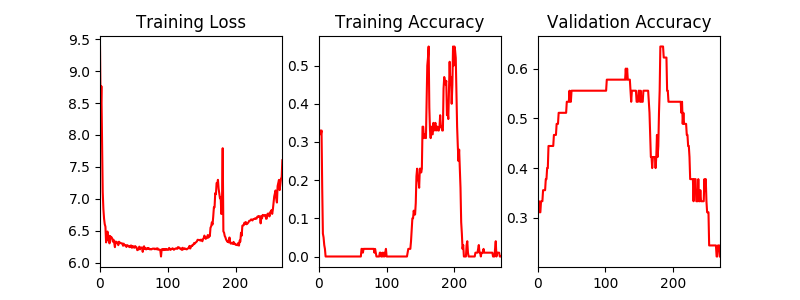

/Users/arielril/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
/Users/arielril/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
/Users/arielril/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0


In [ ]:
"""Nao alterar esta celula"""
# Cria o grafico e atualiza os pesos
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,3))
ax1.set_title('Training Loss')
ax2.set_title('Training Accuracy')
ax3.set_title('Validation Accuracy')

t = tqdm(range(epochs))
losses = []
training_accuracy = []
accuracy = []

# Visualizacao do treinamento
drawn, = ax1.plot(np.arange(0), losses, c='r')
drawn2, = ax2.plot(np.arange(0), training_accuracy, c='r')
drawn3, = ax3.plot(np.arange(0), accuracy, c='r')

# Loop de treinamento
for e in t:
    # aleatoriza o treino e zera estatisticas
    df = df.sample(frac=1., random_state=SEED)
    total_loss = 0
    correct = 0
    total = 0
    # Loop da epoca
    # range from 0 to df.shape[0]-batch_size, step = batch_size
    for i in range(0, df.shape[0]-batch_size, batch_size):
        total += batch_size
        batch = df.iloc[i:(i+batch_size), :]
        y = df.iloc[i:(i+batch_size)]
        y = y.loc[:, "target"]
        batch = batch.drop(["target"], axis=1)
        predictions = network.forward(batch.values)
        loss, grads = network.backward(y)
        total_loss += loss
        network.optimize()
        correct += sum(y.values == predictions.argmax(axis=1))
    
    # Atualiza estatisticas e graficos
    training_accuracy.append(correct/total)
    losses.append(total_loss)
    t.set_description('Loss: %.3f' % total_loss)
    drawn.set_data((np.arange(len(losses)), losses))
    ax1.relim()
    ax1.set_xlim((0, e))
    ax1.autoscale_view()
    drawn2.set_data((np.arange(len(training_accuracy)), training_accuracy))
    ax2.relim()
    ax2.set_xlim((0, e))
    ax2.autoscale_view()
    
    ### VALIDACAO ###
    
    batch = df_val
    y = df_val.loc[:, "target"]
    batch = batch.drop(["target"], axis=1)
    predictions = network.forward(batch.values)
    correct = np.sum(y.values == predictions.argmax(axis=1))
    accuracy.append(correct/df_val.shape[0])
    
    # Atualiza grafico de validacao
    drawn3.set_data((np.arange(len(accuracy)), accuracy))
    ax3.relim()
    ax3.set_xlim((0, e))
    ax3.autoscale_view()
    fig.canvas.draw()